In [81]:
import numpy as np
import matplotlib.pyplot as plt

In [82]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("fast_output_file", "C:/code/openfast_toolbox/openfast_toolbox/io/fast_output_file.py")
fastio = importlib.util.module_from_spec(spec)
sys.modules["fast.io"] = fastio
spec.loader.exec_module(fastio)

CSVFile not available


In [84]:
fast_out_200 = fastio.FASTOutputFile('F:/Documents/WETO Incubator/OpenFAST/VolturnUS15MW/VolturnUS-15MW_Cat_200m.outb')
fast_out_500 = fastio.FASTOutputFile('F:/Documents/WETO Incubator/OpenFAST/VolturnUS15MW/VolturnUS-15MW_Cat_500m.outb')
fast_out_1000 = fastio.FASTOutputFile('F:/Documents/WETO Incubator/OpenFAST/VolturnUS15MW/VolturnUS-15MW_Taut_1000m.outb')

In [85]:
fast_df_200 = fast_out_200.toDataFrame()
fast_df_500 = fast_out_500.toDataFrame()
fast_df_1000 = fast_out_1000.toDataFrame()

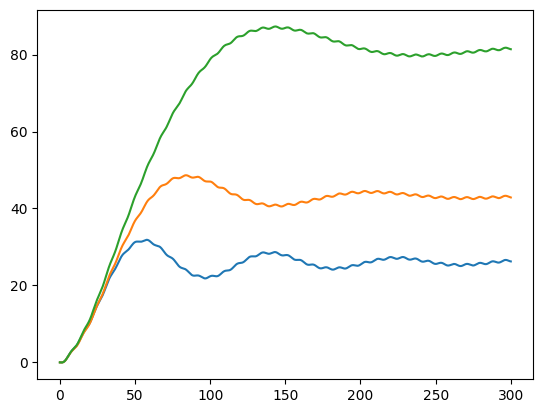

In [86]:
plt.plot(fast_df_200['Time_[s]'], fast_df_200['PtfmSurge_[m]'])
plt.plot(fast_df_500['Time_[s]'], fast_df_500['PtfmSurge_[m]'])
plt.plot(fast_df_1000['Time_[s]'], fast_df_1000['PtfmSurge_[m]'])

In [2]:
mooring_type = 'catenary' #taut
depth = 1000
fairlead_z = -14
diameter = 0.300
massden = 38.5
taut_angle = 60

In [3]:
def get_init_line_length_cat(depth, diameter, massden):
    # Proof load of mooring line (assumes chain)
    t_max = 0.0156 * diameter ** 2. * (44. - 0.08 * diameter)

    # Initial line length estimate used in Kim et al.=
    return round(depth * np.sqrt(2. * (t_max / (massden * depth)) - 1.), 3)

In [10]:
def get_init_line_length_taut(depth, fairlead_z, angle):
    h = depth - fairlead_z
    # angle is from vertical at fairlead
    l = h * np.arctan(np.deg2rad(angle))
    print(l)
    print(l + -58)
    return np.sqrt(h**2 + l**2)

In [32]:
def get_freq_props(ts, dt):
    sp2 = np.fft.fft(ts)
    sp = sp2[:len(sp2) // 2] * 2 # single-sided spectrum
    sp_norm = np.abs(sp) / np.sum(np.abs(sp))
    freq = np.fft.fftfreq(len(ts), d=dt)[:len(sp)]
    return sp, freq

In [33]:
sp, freq = get_freq_props(fast_df['PtfmSurge_[m]'], 0.025)

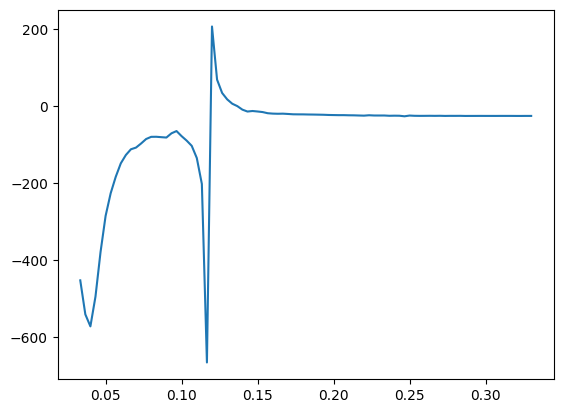

In [37]:
plt.plot(freq[10:100], sp[10:100])

In [ ]:
def get_45deg_taut_props(z_seabed, fairlead_coords, theta, ref_ea, ref_unstr_len):
    z = abs(z_seabed - fairlead_coords[0, 2])
    unstr_len = z / .707
    anch_x = fairlead_coords[:, 0] + z * np.cos(theta)
    anch_y = fairlead_coords[:, 1] + z * np.sin(theta)
    anch_z = np.repeat(z_seabed, 3)
    anch_coords = np.column_stack((anch_x, anch_y, anch_z))
    ea = ref_ea / ref_unstr_len * unstr_len
    return unstr_len, anch_coords, ea

In [11]:
line_len = get_init_line_length_taut(-1000, -14, 30)

-475.59503640161057
-533.5950364016105


In [12]:
np.cos(np.deg2rad(30)) * line_len

948.0453464826389

In [13]:
line_len

1094.7084719914471

In [ ]:
fairlead_coords = np.array([[-58,      0, -14],
                            [ 29, 50.229, -14],
                            [ 29,-50.229, -14]])
thetas = np.array([np.pi, np.pi/3, 2*np.pi - np.pi/3])
ref_ea = 3.27e9
ref_unstr_len = 850

In [ ]:
get_45deg_taut_props(-1000, fairlead_coords, thetas, ref_ea, ref_unstr_len)

In [ ]:
def get_positions(depth, diameter, massden, fairlead_xyz):
    """
    Places the anchor points in the correct location to make it proportional to the baseline setup, even if the
    water depth has changed. The procedure used in this is based on research by Kim et al. in
    'Design of Mooring Lines of Floating Offshore Wind Turbine in Jeju Offshore Area', 2014
    """

    # Proof load of mooring line (assumes chain)
    l_proof = get_initial_line_length(depth, fairlead_xyz, diameter, massden)

    # Horizontal distance between fairlead and anchor
    hor_anchor_distance = (
        ((t_max - massden*depth) / massden)
        * np.acosh(1 + depth * (massden / (t_max - massden * depth))))

    anchor_x = np.zeros(len(line_angles))
    anchor_y = np.zeros(len(line_angles))

    for idx in np.arange(len(line_angles)):
        anchor_x[idx] = fairlead_x[idx] + hor_anchor_distance * math.cos(math.radians(line_angles[idx]))
        anchor_x[idx] = round(anchor_x[idx], 3)
        anchor_y[idx] = fairlead_y[idx] + hor_anchor_distance * math.sin(math.radians(line_angles[idx]))
        anchor_y[idx] = round(anchor_y[idx], 3)

    print('Anchor positions identified.')
    return anchor_x, anchor_y